<a href="https://colab.research.google.com/github/omkargolatkar/actin_analysis/blob/main/Actin_dataset_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Actin dataset generation

The following notebook is used for
1. creating **dataset of all actin entities** from the pdb
2. separating **"actin filaments"** from **"non-filament actin"** structures


## Install and import required modules

modules:
1. python-grpahql-client
2. rcsbsearchapi

In [ ]:
!pip install python-graphql-client
!pip install rcsbsearchapi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rcsbsearchapi: filename=rcsbsearchapi-1.4.2-py2.py3-none-any.whl size=163533 sha256=8effda70799622837f18a3329dce70b33c5629edb39c4ca98b6f98b3b0518d2f
  Stored in directory: /root/.cache/pip/wheels/26/fe/3f/a1d2a0110ddf201fc3810c9c2097454f39d9ef227ea66c41c5
Successfully built rcsbsearchapi


In [ ]:
from rcsbsearchapi.search import TextQuery, AttributeQuery
from rcsbsearchapi import rcsb_attributes as attrs
from rcsbsearchapi.search import SequenceQuery
from python_graphql_client import GraphqlClient
import json
import requests
import os
from collections import Counter
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import data_table
from IPython.display import HTML, display
import time

## Search API to find actin containing structures

Using 'rcsbsearchapi', we can get the PDB ids (2OAN), entity ids (2OAN_1) or assembly ids (2OAN_1).

We'll use these as an input to PDB-data-API to get detailed information (resolution, accession id, etc) about them.




In [ ]:
#@title Actin entities

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

sequence_similarity_cutoff = 54 # @param {type:"integer"}
e_value_cutoff = 0.1 # @param {type:"number"}
query_sequence = "MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVGMGQKDSYVGDEAQSKRGILTLKYPIEHGIVTNWDDMEKIWHHTFYNELRVAPEEHPVLLTEAPLNPKANREKMTQIMFETFNTPAMYVAIQAVLSLYASGRTTGIVMDSGDGVTHTVPIYEGYALPHAILRLDLAGRDLTDYLMKILTERGYSFTTTAEREIVRDIKEKLCYVALDFEQEMATAASSSSLEKSYELPDGQVITIGNERFRCPEALFQPSFLGMESCGIHETTFNSIMKCDVDIRKDLYANTVLSGGTTMYPGIADRMQKEITALAPSTMKIKIIAPPERKYSVWIGGSILASLSTFQQMWISKQEYDESGPSIVHRKCF" # @param {type:"string"}
# remove whitespaces
query_sequence = "".join(query_sequence.split())
#@markdown - Sequence used : **Human cytoplasmic Actin - P60709**
entrypoint = "polymer_entity" #@param ["entry", "polymer_entity","assembly"]

q_seq = SequenceQuery(query_sequence, evalue_cutoff = e_value_cutoff, identity_cutoff = sequence_similarity_cutoff*0.01)

actin_ids = []
for id in q_seq(entrypoint):
   actin_ids.append(id)

entrypoint_dict = {
    'entry':'structures',
    'polymer_entity': 'entities',
    'assembly':'assemblies'}

print("There are {number} {types} in the PDB".format(number=len(actin_ids), types = entrypoint_dict[entrypoint]),":",actin_ids[0:5],"....")

There are 468 entities in the PDB : ['2OAN_1', '3U4L_1', '6ANU_1', '6F1T_2', '6F38_2'] ....


In [ ]:
#@title Actin entities (helical symmetry)

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

sequence_similarity_cutoff = 54 # @param {type:"integer"}
e_value_cutoff = 0.1 # @param {type:"number"}
query_sequence = "MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVGMGQKDSYVGDEAQSKRGILTLKYPIEHGIVTNWDDMEKIWHHTFYNELRVAPEEHPVLLTEAPLNPKANREKMTQIMFETFNTPAMYVAIQAVLSLYASGRTTGIVMDSGDGVTHTVPIYEGYALPHAILRLDLAGRDLTDYLMKILTERGYSFTTTAEREIVRDIKEKLCYVALDFEQEMATAASSSSLEKSYELPDGQVITIGNERFRCPEALFQPSFLGMESCGIHETTFNSIMKCDVDIRKDLYANTVLSGGTTMYPGIADRMQKEITALAPSTMKIKIIAPPERKYSVWIGGSILASLSTFQQMWISKQEYDESGPSIVHRKCF" # @param {type:"string"}
# remove whitespaces
query_sequence = "".join(query_sequence.split())
#@markdown - Sequence used : **Human cytoplasmic Actin - P60709**
entrypoint = "entry" #@param ["entry", "polymer_entity","assembly"]
symmetry_symbol =  "H" #@param ["H"]

q_hel = attrs.rcsb_struct_symmetry.symbol == symmetry_symbol
q_seq = SequenceQuery(query_sequence, evalue_cutoff = e_value_cutoff, identity_cutoff = sequence_similarity_cutoff*0.01)

query = q_seq & q_hel
actin_H_ids = []
for id in query(entrypoint):
   actin_H_ids.append(id)

entrypoint_dict = {
    'entry':'structures',
    'polymer_entity': 'entities',
    'assembly':'assemblies'}

print("There are {number} {types} in the PDB".format(number=len(actin_H_ids), types = entrypoint_dict[entrypoint]),":",actin_ids[0:5],"....")

There are 196 structures in the PDB : ['2OAN_1', '3U4L_1', '6ANU_1', '6F1T_2', '6F38_2'] ....


## PDB data API
Make sure you have selected **polymer_entity** as entrypoint in the above cell

Use data API for generating dataset
*   add or remove query variables to decide what to include in the dataset
*   the output is a json object with information about all the actin entities listed in the result of search API

Current query variables:
1. entry_id: 1ABC_1
2. experimental method: "X-ray crystallography"
3. resolution: 3 Å
4. structure title:
5. assembly symmetry type: "helical, assymetric"
6. entity sequence:
7. entity name:
8. pdb chain id:
9. author chain id:
10. uniprot id:

In [ ]:
#@title Check for right sequence similarity cutoff and generate dataset
ids_lst = json.dumps(actin_ids)
query = '''
{
  polymer_entities(entity_ids: %s) {
    rcsb_id
    entry {
      exptl {
        method
      }
      rcsb_entry_container_identifiers {
        entry_id
      }
      rcsb_entry_info {
        resolution_combined
      }
      struct {
        title
      }
      assemblies {
        rcsb_struct_symmetry {
          type
        }
      }
    }
    entity_poly {
      pdbx_seq_one_letter_code_can
      rcsb_sample_sequence_length
    }
    rcsb_polymer_entity {
      pdbx_description
    }
    polymer_entity_instances {
      rcsb_polymer_entity_instance_container_identifiers {
        asym_id
        auth_asym_id
      }
    }
    rcsb_polymer_entity_container_identifiers {
      reference_sequence_identifiers {
        database_accession
        database_name
      }
    }
  }
}
'''
data_query = query % (ids_lst)

url_data_api = "https://data.rcsb.org/graphql" # @param {type:"string"}
client = GraphqlClient(endpoint = url_data_api)
result = client.execute(query=data_query)
result = result['data']

print("\033[1m"+"Data API output"+"\033[0;0m")
pprint(result['polymer_entities'][0:1])
print('')

to_ignore = "actin,Actin,ACTIN" #@param {type:"string"}
#@markdown - to_ignore : `,` separated list of what to ignore in the entity name
to_notice = "related,dynactin,Dynactin,DYNACTIN" #@param {type: "string"}
#@markdown - to_notice : `,` separated list of what to notice in the entity name

print("\033[1m"+"Suspicious entities:"+"\033[0;0m")
for entity in result['polymer_entities']:
  entity_name = entity['rcsb_polymer_entity']['pdbx_description']
  if any(elem in entity_name for elem in to_notice.split(",")):
    print(entity['rcsb_id'], ": ",entity_name)
  elif any(elem in entity_name for elem in to_ignore.split(",")):
      pass
  else:
      print(entity['rcsb_id'], ": ",entity_name)

json_object = json.dumps(result, indent=4)
#### set 1 (to set sequence similarity cutoff)
#based on the list of entities obtained from search API, fix the sequence similarity cutoff so that the list won't contain any non-actin entities

#This will print the name and pdb_id of entities which do not have actin in their name or has ('related', 'dynactin') in the name

Data API output
[{'entity_poly': {'pdbx_seq_one_letter_code_can': 'MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVGMGQKDSYVGDEAQSKRGILTLKYPIEHGIVTNWDDMEKIWHHTFYNELRVAPEEHPVLLTEAPLNPKANREKMTQIMFETFNTPAMYVAIQAVLSLYASGRTTGIVMDSGDGVTHTVPIYEGYALPHAILRLDLAGRDLTDYLMKILTERGYSFTTTAEREIVRDIKEKLCYVALDFEQEMATAASSSSLEKSYELPDGQVITIGNERFRCPEALFQPSFLGMESCGIHETTFNSIMKCDVDIRKDLYANTVLSGGTTMYPGIADRMQKEITALAPSTMKIKIIAPPERKYSVWIGGSILASLSTFQQMWISKQEYDESGPSIVHRKCF',
                  'rcsb_sample_sequence_length': 375},
  'entry': {'assemblies': [{'rcsb_struct_symmetry': [{'type': 'Asymmetric'},
                                                     {'type': 'Asymmetric'}]}],
            'exptl': [{'method': 'ELECTRON MICROSCOPY'}],
            'rcsb_entry_container_identifiers': {'entry_id': '6ZNO'},
            'rcsb_entry_info': {'resolution_combined': [6.8]},
            'struct': {'title': 'The pointed end complex of dynactin with the '
                                'p150 projection docked'}},
  'polymer_e

In [ ]:
#@title JSON to Dataframe
#@markdown - For better visualization, convert the json object obtained from data API to a dataframe
#@markdown - Each row of the dataframe corresponds to a single actin entity
# df is a dataframe with 468 actin entities as of 02/01/2023
master_lst = []
error_lst = []
for entity in result['polymer_entities']:
  entity_id = entity['rcsb_id']
  try:
    entity_seq = entity['entity_poly']['pdbx_seq_one_letter_code_can']
    entity_seq_length = entity['entity_poly']['rcsb_sample_sequence_length']
    accessions = []
    for acc in entity['rcsb_polymer_entity_container_identifiers']['reference_sequence_identifiers']:
      if acc['database_name'] == "UniProt":
        accessions.append(acc['database_accession'])
    uni_acc = ','.join(accessions)
    entity_uniprot_id = entity['rcsb_polymer_entity_container_identifiers']['reference_sequence_identifiers'][0]['database_accession']
    pdb_resolution = entity['entry']['rcsb_entry_info']['resolution_combined'][0]
    exptl_methods = []
    for method in entity['entry']['exptl']:
      exptl_methods.append(method['method'])
    exptl_method = ','.join(exptl_methods)
    all_sym_in_assembly = []
    for assem in entity['entry']['assemblies']:
      for sym_type in assem['rcsb_struct_symmetry']:
        sym = sym_type['type']
        all_sym_in_assembly.append(sym)
    assembly_symmetry = ','.join(all_sym_in_assembly)
    structure_title = entity['entry']['struct']['title']
    #pdb chains
    pdb_chains = []
    auth_chains = []
    for chain_dict in entity['polymer_entity_instances']:
      pdb_chains.append(chain_dict['rcsb_polymer_entity_instance_container_identifiers']['asym_id'])
      auth_chains.append(chain_dict['rcsb_polymer_entity_instance_container_identifiers']['auth_asym_id'])
    asym_ids = ','.join(pdb_chains)
    auth_asym_ids = ','.join(auth_chains)
    master_lst.append([entity_id,entity_uniprot_id,asym_ids,auth_asym_ids,structure_title,pdb_resolution,assembly_symmetry,entity_seq_length,exptl_method,entity_seq])
  except TypeError:
    # print(entity_id)
    error_lst.append(entity_id)
    try:
      entity_seq = entity['entity_poly']['pdbx_seq_one_letter_code_can']
      entity_seq_length = entity['entity_poly']['rcsb_sample_sequence_length']
      entity_uniprot_id = entity['rcsb_polymer_entity_container_identifiers']['reference_sequence_identifiers'][0]['database_accession']
    except TypeError:
      entity_seq = 'none'
      entity_seq_length = 'none'
      entity_uniprot_id = 'none'
    try:
      pdb_resolution = entity['entry']['rcsb_entry_info']['resolution_combined'][0]
    except TypeError:
      pdb_resolution = 'none'
    try:
      exptl_methods = []
      for method in entity['entry']['exptl']:
        exptl_methods.append(method['method'])
      exptl_method = ','.join(exptl_methods)
    except TypeError:
      exptl_method = 'none'
    try:
      all_sym_in_assembly = []
      for assem in entity['entry']['assemblies']:
        for sym_type in assem['rcsb_struct_symmetry']:
          sym = sym_type['type']
          all_sym_in_assembly.append(sym)
      assembly_symmetry = ','.join(all_sym_in_assembly)
    except TypeError:
      assembly_symmetry = 'none'
    try:
      #pdb chains
      pdb_chains = []
      auth_chains = []
      for chain_dict in entity['polymer_entity_instances']:
        pdb_chains.append(chain_dict['rcsb_polymer_entity_instance_container_identifiers']['asym_id'])
        auth_chains.append(chain_dict['rcsb_polymer_entity_instance_container_identifiers']['auth_asym_id'])
      asym_ids = ','.join(pdb_chains)
      auth_asym_ids = ','.join(auth_chains)
    except TypeError:
      asym_ids = 'none'
      auth_asym_ids = 'none'
    structure_title = entity['entry']['struct']['title']
    master_lst.append([entity_id,entity_uniprot_id,asym_ids,auth_asym_ids,structure_title,pdb_resolution,assembly_symmetry,entity_seq_length,exptl_method,entity_seq])
    pass

df = pd.DataFrame(master_lst,columns=['entity_id','uniprot_id','pdb_chain_id','auth_chain_id','structure_title','resolution','symmetry','seq_length', 'method','pdb_sequence'])
df.index+=1

print("Entities which have some missing field: ", error_lst,"\n")
#'6V6S_7', '8J07_67', '2W49_5', '2W4U_5', '7U8K_1'have at least one of the query variables missing

data_table.DataTable(df)

Entities which have some missing field:  ['6V6S_7', '8J07_67', '2W49_5', '2W4U_5', '7U8K_1'] 



,entity_id,uniprot_id,pdb_chain_id,auth_chain_id,structure_title,resolution,symmetry,seq_length,method,pdb_sequence
1,6ZNO_2,Q6QAQ1,B,H,The pointed end complex of dynactin with the p...,6.8,"Asymmetric,Asymmetric",375,ELECTRON MICROSCOPY,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...
2,7PDZ_3,P60712,"C,D,E,G,H,F","I,J,K,N,O,L",Structure of capping protein bound to the barb...,3.8,"Asymmetric,Asymmetric,Helical",375,ELECTRON MICROSCOPY,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...
3,7QJ5_2,A0A6I9HGD1,C,e,Structure of recombinant human gamma-Tubulin R...,8.7,"Asymmetric,Asymmetric",375,ELECTRON MICROSCOPY,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...
4,7QJ8_3,A0A6I9HGD1,D,e,Structure of recombinant human gamma-Tubulin R...,8.7,"Asymmetric,Asymmetric",375,ELECTRON MICROSCOPY,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...
5,7Z8F_2,Q6QAQ1,H,H,Composite structure of dynein-dynactin-BICDR o...,20.0,"Asymmetric,Asymmetric,Helical,Cyclic,Cyclic",375,ELECTRON MICROSCOPY,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...
...,...,...,...,...,...,...,...,...,...,...
464,8OI8_1,P60709,"E,A,B,C,D","E,C,A,B,D","Cryo-EM structure of ADP-bound, filamentous be...",2.28,Helical,375,ELECTRON MICROSCOPY,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...
465,8OID_1,P60709,"A,B,C,D,E","C,A,B,D,E","Cryo-EM structure of ADP-bound, filamentous be...",2.3,Helical,375,ELECTRON MICROSCOPY,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...
466,8ORD_1,F1RCB6,"A,B,D,E,C","A,B,D,E,C",Cryo-EM map of zebrafish cardiac F-actin,3.9,Helical,377,ELECTRON MICROSCOPY,MCDEEETTALVCDNGSGLVKAGFAGDDAPRAVFPSIVGRPRHQGVM...
467,8SYF_2,P68139,"C,D","C,D",Homology model of Acto-HMM complex in ADP-stat...,19.0,Asymmetric,375,ELECTRON MICROSCOPY,DEDETTALVCDNGSGLVKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...


## PDBe-GRAPH API

### Download assembly information
To get the **number of copies** for each entity in an assembly, we need to download the assembly information

Note: (The information is downloaded for only 195* pdb ids for which symmetry type is 'helical', since non-helical pdb ids won't contain actin filament)

example: https://www.ebi.ac.uk/pdbe/api/pdb/entry/assembly/2oan

This information is used to separate actin filaments from the dataset

In [ ]:
#@title Assembly information
api_url = "https://www.ebi.ac.uk/pdbe/api/pdb/entry/assembly" #@param {type: "string"}
PDB_ids = [item for item in actin_H_ids]

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

out = display(progress(0, 100), display_id=True)

def get_assembly_info(pdb_id,api_url):
  # Make a GET call to the API URL
    get_request = requests.get(url=api_url+"/"+pdb_id)

    if get_request.status_code == 200:
        # If there is data returned (with HTML status code 200)
        # then return the data in JSON format
        return get_request.json()
    else:
        # If there is no data, print status code and response
        print(get_request.status_code, get_request.text)
        return None

bar_val = 0
for pdb_id in PDB_ids:
  completeName = "/content/drive/MyDrive/Omkar_Masters_thesis/actin_dataset/assemblies" +"/"+pdb_id+".json"
  if os.path.exists(completeName) == False:
    assembly_info = get_assembly_info(pdb_id,api_url) # a dictionary
    json_object = json.dumps(assembly_info, indent=4)
    with open(completeName, "w") as outfile:
      outfile.write(json_object)
  #print("done "+pdb_id)
  bar_val += 1
  out.update(progress(bar_val,len(PDB_ids)))

### generate filament and (non-filament+filament) database


*   separate the pdb ids which have less than 3 number of copies of actin entity in all of the assemblies
*   curate the filament dataset to ensure that only actin filaments are involed
*   download the final dataframes: 'actin_filament_entities_NA.xlsx' and 'actin_all_entities_NA.xlsx'



In [ ]:
# actin entities with less than 3 copies

df2 = pd.DataFrame() # all helical symmetry structures -> 201 actin entities which are a part of helical assemblies (19/12/2023)
filaments = []
for index, row in df.iterrows():
	if 'Helical' in row['symmetry']:
		filaments.append(row.to_dict())
df2 = pd.DataFrame.from_records(filaments)
df2.reset_index()

PDB_ids = [x[0:4] for x in list(df2['entity_id'])] # pdb ids of the above mentioned actin entities
entity_ids = list(df2['entity_id'])
act_3_pdbs = []
act_more_than_3_pdbs = []

for pdb_id in PDB_ids:
	completeName = "/content/drive/MyDrive/Omkar_Masters_thesis/actin_dataset/assemblies/"+pdb_id+".json"
	actin_entities = [int(x.partition('_')[2]) for x in entity_ids if pdb_id in x]
	with open(completeName, 'r') as openfile:
		result = json.load(openfile)
		for assembly in result[pdb_id.lower()]:
			for entity in assembly['entities']:
				if entity['entity_id'] in actin_entities:
					if entity['number_of_copies'] < 3:
#						print(pdb_id)
						act_3_pdbs.append(pdb_id)
					else:
						act_more_than_3_pdbs.append(pdb_id)

common_pdbs = list(np.intersect1d(act_3_pdbs,act_more_than_3_pdbs)) # this list has pdb ids in which number of copies of actin entity differ in multiple assemblies (2YJF) or malformed annotation (3B63)

In [ ]:
count_of_act_3 = Counter(act_3_pdbs) # check those which have count of more than 1
for key, value in count_of_act_3.items():
  if value > 1:
    print(key, value)
count_of_act_more_than_3 = Counter(act_more_than_3_pdbs) # check those which have count of more than 1
print("\n")
for key, value in count_of_act_more_than_3.items():
  if value > 1:
    print(key, value)

2YJF 2
3B63 42


3B63 7


In [ ]:
filaments_curated = []
print(act_3_pdbs)
#print(list(df2['entity_id']))
act_3_entities = []

for elem in list(df2['entity_id']):
	if any(act_3_pdb in elem for act_3_pdb in act_3_pdbs):
		act_3_entities.append(elem)
print(act_3_entities)

# manually check for entities in the above list (act_3_entities) if all of them have less than 3 actin entities
# 3B63 is actually a filament
duplicate_entities_pdb = [entity[0:4] for entity in act_3_entities]
counter_dict = Counter(duplicate_entities_pdb) #{'5ADX': 1, '2YJF': 1, '3B63': 7,..}

act_3_entities_curated = []
for key, value in counter_dict.items():
  if value>1:
    for entity in act_3_entities:
      if entity.startswith(key):
        pass
      else:
        act_3_entities_curated.append(entity)
print(act_3_entities_curated) # non-filament actin entities which are part of helical assemblies but number of copies is less than 3

filament_check = pd.read_excel("/content/drive/MyDrive/Omkar_Masters_thesis/actin_dataset/actin_database_sheets/actin_filament_entities_NA.xlsx") # actin filament list as of 19/12/2023

for index, row in df2.iterrows():
	if any(arp_ent in row['entity_id'] for arp_ent in act_3_entities_curated):
		pass
	else:
		filaments_curated.append(row.to_dict())
df3 = pd.DataFrame.from_records(filaments_curated) # df2 filtered for supposedly actin filaments after checking for no of actin chains in assemblies
df3.index+=1

# manual check for filaments
for index, row in df3.iterrows():
	if any(elem in row['structure_title'] for elem in ["F-actin","filament","f-actin","Filament","F-Actin","FILAMENT","F-ACTIN","myosin","Myosin"]): # check myosin
		pass
	elif any(elem in row['method'] for elem in ['X-RAY DIFFRACTION', 'FIBER DIFFRACTION','ELECTRON CRYSTALLOGRAPHY','SOLID-STATE NMR']):
		print(row['entity_id'], " not EM")
	elif any(elem in row["entity_id"] for elem in list(filament_check['entity_id'])):
		pass
	else:
		print(row["entity_id"])

# 3TPQ is not filament
df3 = df3[df3.entity_id != '3TPQ_1'] # final curated df3 exclusively containing actin filaments
df3.reset_index(inplace=True)
df3.index+=1
df3 = df3.iloc[:,1:]

# add filament status in the original dataset
df['filament_status'] = 'non_filament'

for index, row in df.iterrows():
	if any(elem in row['entity_id'] for elem in list(df3['entity_id'])):
		df.at[index, 'filament_status'] = row['filament_status'].replace("non_filament","filament")

savepath = "/content/drive/MyDrive/Omkar_Masters_thesis/actin_dataset/actin_database_sheets"# add a date to the name
df3.to_excel(os.path.join(savepath,"actin_filament_entities_NA.xlsx"))
df.to_excel(os.path.join(savepath,"actin_all_entities_NA.xlsx"))


['7Z8F', '2YJF', '2YJF', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '3B63', '5ADX', '5AFU', '5NW4', '6F1T', '6F38', '6F3A', '6ZNL']
['7Z8F_2', '2YJF_1', '3B63_1', '3B63_2', '3B63_3', '3B63_4', '3B63_5', '3B63_6', '3B63_7', '5ADX_2', '5AFU_6', '5NW4_11', '6F1T_2', '6F38_2', '6F3A_2', '6ZNL_2']
['7Z8F_2', '2YJF_1', '5ADX_2', '5AFU_6', '5NW4_11', '6F1T_2', '6F38_2', '6F3A_2', '6ZNL_2']
3TPQ_1  not EM


## Final database numbers

In [ ]:
# final numbers
# actin structures
all_actin_entities = list(df['entity_id'])
all_actin_pdbs = list(set([entity[0:4] for entity in all_actin_entities]))

all_actin_filament_entities = list(df3['entity_id'])
all_actin_filament_pdbs = list(set([entity[0:4] for entity in all_actin_filament_entities])) # list of pdb ids of all actin filaments (185 as of 19/12/2023)
print(all_actin_filament_pdbs)
print("number of structures which have actin filament: ", len(all_actin_filament_pdbs))

all_actin_pdb_dict = {}
for pdb in all_actin_pdbs:
  all_actin_pdb_dict[pdb] = 'non-filament'
for pdb in all_actin_filament_pdbs:
  all_actin_pdb_dict[pdb] = 'filament'

df_actin_pdb_status = pd.DataFrame(list(all_actin_pdb_dict.items()), columns=['pdb_id', 'status'])
df_actin_pdb_status.index+=1
df_actin_pdb_status.to_excel(os.path.join(savepath,"actin_filament_status.xlsx"))

['7U8K', '7RB9', '1O1G', '1O19', '3J82', '5KG8', '6CXI', '1MVW', '6DJM', '6T23', '7PDZ', '6ANU', '6M5G', '5NOG', '7SX9', '6DJN', '5OOD', '6KN8', '8EFI', '6UC0', '7QIN', '8F8Q', '8D17', '6C1D', '8DMY', '5YU8', '6T25', '8CCO', '6T24', '5NOJ', '7SXA', '8ENC', '6DJO', '4A7F', '8ORD', '3B63', '7UUW', '6X5Z', '4A7N', '3J8A', '1O18', '8OH4', '7K20', '3BYH', '1O1D', '7SX8', '7UTJ', '8OI8', '7ALN', '7R8V', '8A2T', '8DNF', '6BNU', '8D16', '8OI6', '1O1B', '3J8J', '7Z7H', '6CXJ', '8F8S', '6BNQ', '3MFP', '7KON', '1O1C', '7NEP', '6KLL', '7KO4', '4A7L', '7ZTC', '6BNP', '6UBY', '7BTI', '7P1G', '8F8P', '6AVB', '7AQK', '7PLZ', '5OOC', '6BNW', '4M63', '2W4U', '5ONV', '7UDT', '5OOF', '7R94', '8Q4G', '6BNO', '7KO7', '6D8C', '8F8R', '6KN7', '7KOR', '5JLH', '6UPV', '8D18', '7TIT', '8CCN', '5OOE', '7LRG', '8A2Z', '6KLN', '1O1E', '2W49', '6TU4', '3LUE', '8D14', '7PME', '6UC4', '6C1G', '6FHL', '7JH7', '8EFH', '3B5U', '6T1Y', '5MVY', '3J8K', '7ZTD', '6W17', '7AD9', '7K21', '8IAI', '7QIM', '1O1A', '8D15', '8E9B',

non-filament actin structures:  {'3': 185, '3.5': 227, '4': 243, '4.5': 250, '5': 252, '5.5': 253, '6': 253, 'no_cutoff': 275}
filament actin structures:  {'3': 28, '3.5': 64, '4': 107, '4.5': 113, '5': 119, '5.5': 122, '6': 124, 'no_cutoff': 186}


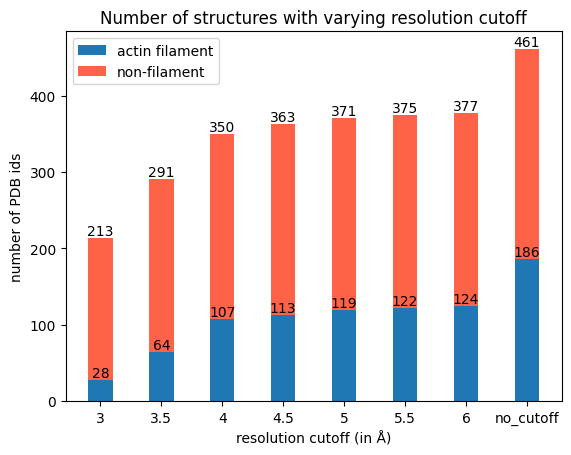

In [ ]:
plot_dict = {}
plot_dict2 = {}
master_lst =[]
master_lst2 = []
res_cutoff = [3,3.5,4,4.5,5,5.5,6]
no_res_list_all = []
no_res_list_f = []

for ress in res_cutoff:
	loop_lst = []
	for index,row in df.iterrows():
		res = row['resolution']
		#res = res[:-1]
		try:
			if float(res) <= ress:
				loop_lst.append(row['entity_id'][0:4])
		except ValueError:
			no_res_list_all.append(row['entity_id'][0:4])
			pass
	loop_lst = list(set(loop_lst))
	master_lst.append(len(loop_lst))
	loop_lst2 = []

	for index,row in df3.iterrows():
		res = row['resolution']#[1:]
		#res = res[:-1]
		try:
			if float(res) <= ress:
				loop_lst2.append(row['entity_id'][0:4])
		except ValueError:
			no_res_list_f.append(row['entity_id'][0:4])
			pass
	loop_lst2 = list(set(loop_lst2))
	master_lst2.append(len(loop_lst2))
#print(master_lst,master_lst2)

no_res_list_all = list(set(no_res_list_all))
no_res_list_f = list(set(no_res_list_f))

for i in range(0,len(res_cutoff)):
  plot_dict[str(res_cutoff[i])] = master_lst[i] - master_lst2[i]

plot_dict['no_cutoff'] = len(all_actin_pdbs) - len(all_actin_filament_pdbs)

for i in range(0,len(res_cutoff)):
  plot_dict2[str(res_cutoff[i])] = master_lst2[i]

plot_dict2['no_cutoff'] = len(all_actin_filament_pdbs)

print("non-filament actin structures: ", plot_dict)
print("filament actin structures: ", plot_dict2)

x = list(plot_dict.keys())
y1 = list(plot_dict.values())
y2 = list(plot_dict2.values())

fig, ax = plt.subplots()

bars2 = ax.bar(x,y2, width = 0.4, label = 'actin filament')
ax.bar_label(bars2)
bars = ax.bar(x,y1,bottom = y2,color = 'tomato',width= 0.4, label = 'non-filament')
ax.bar_label(bars)
ax.legend()
plt.xlabel('resolution cutoff (in Å)')
plt.ylabel('number of PDB ids')
plt.title('Number of structures with varying resolution cutoff')
plt.show()